In [ ]:
# =========================
# XGB_prototype.ipynb — patched for tradability gating (Cell 1)
# =========================
from __future__ import annotations

import gc, os, sys, math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping, EvaluationMonitor

import shap
import optuna
from packaging import version

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
)

# ---- project config ----
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)
import config as config  # must live in PYTHONPATH or same dir

c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ---- paths ---- (Cell 2)
CSV_PATH = str(config.PROCESSED_CSV)
OUTPUT_PLOT = str(config.XGB_CONFUSION_MATRIX_PLOT)
OUTPUT_PREDICTIONS = str(config.PREDICTIONS_CSV)
OUTPUT_SHAP = str(config.OUTPUTS_DIR / "shap_feature_importance.csv")

In [3]:
# Collect and sort data (Cell 3)
df = pd.read_csv(CSV_PATH)
df = df.sort_values("timestamp").reset_index(drop=True)

In [4]:
# Ensure tradable column exists (fallback=1 if older CSVs) (Cell 4)
if "tradable" not in df.columns:
    df["tradable"] = 1
df["tradable"] = df["tradable"].astype("int8")

# Downcast floats for speed
to_cast = [
    c for c in df.select_dtypes("float64").columns
    if c not in ("timestamp", "mid_price")
]
df[to_cast] = df[to_cast].astype("float32")

In [18]:
# =========================
# Labels (asymmetric; prefers robust targets if present) — REPLACE Cell 5
# =========================
# Thresholds (edit as needed)
UP_TAU = 0.08                  # require strong future up move (e.g., +10%)
DN_TAU_BASE = 0.03             # flag small down moves (e.g., 3%)
USE_VOL_SCALED_DN = False       # make DN threshold scale with short vol
VOL_COL = "vol_60"             # if available from preparer
DN_TAU_MIN = 0.015             # never below 1.5%
DN_VOL_MULT = 0.75             # DN threshold ≈ 0.75 * vol_60

# Choose which target columns to use (prefer robust quantile/median -> fallback to extrema)
if {"target_q_up_rel","target_q_dn_rel"}.issubset(df.columns):
    up_rel_series = df["target_q_up_rel"].astype(np.float32)
    dn_rel_series = df["target_q_dn_rel"].astype(np.float32)
else:
    # fallback: use legacy extrema labels
    up_rel_series = df["target_max_rel"].astype(np.float32)
    dn_rel_series = (-df["target_min_rel"]).astype(np.float32)  # make positive magnitude

# Optional volatility scaling for DN threshold
if USE_VOL_SCALED_DN and (VOL_COL in df.columns):
    vol = df[VOL_COL].astype(np.float32).fillna(0.0)
    dn_tau_eff = np.maximum(DN_TAU_MIN, DN_VOL_MULT * vol.values)
else:
    dn_tau_eff = np.full(len(df), DN_TAU_BASE, dtype=np.float32)

def to_dir_asym(up_rel_val: float, dn_rel_val: float, dn_tau: float) -> int:
    # +1 if robust future up >= UP_TAU
    if np.isfinite(up_rel_val) and (up_rel_val >= UP_TAU):
        return 1
    # -1 if robust future down >= dn_tau (i.e., likely adverse drift)
    if np.isfinite(dn_rel_val) and (dn_rel_val >= dn_tau):
        return -1
    return 0

# Vectorized map
y_dir = np.fromiter(
    (to_dir_asym(u, d, t) for u, d, t in zip(up_rel_series.values, dn_rel_series.values, dn_tau_eff)),
    count=len(df),
    dtype=np.int8
)

# Encode {-1,0,1} → {0,1,2} (same mapping as before)
_map = {-1: 0, 0: 1, 1: 2}
_inv = np.array([-1, 0, 1])
y = np.fromiter((_map[int(v)] for v in y_dir), count=y_dir.shape[0], dtype=np.int8)

counts = np.bincount(y, minlength=3)
print(f"Rows: {len(df):,} | Class counts (−1,0,1): {{-1:{int(counts[0])}, 0:{int(counts[1])}, 1:{int(counts[2])}}}")


Rows: 6,872,206 | Class counts (−1,0,1): {-1:92389, 0:6749429, 1:30388}


In [23]:
# =========================
# Feature matrix (Cell 6) — LEAK-PROOF
# =========================
passthrough_base = {
    "item", "timestamp", "mid_price", "tradable",
    # legacy targets (kept as passthrough but NOT features)
    "target_min_abs", "target_max_abs", "target_min_rel", "target_max_rel",
}

# Dynamically exclude any present/future label columns (robust ones included)
leak_prefixes = ("target_",)   # extend if you add other forward-looking cols (e.g., "fwd_")
leak_cols = {c for c in df.columns if any(c.startswith(p) for p in leak_prefixes)}
passthrough = passthrough_base | leak_cols

feature_cols = [c for c in df.columns
                if (c not in passthrough) and pd.api.types.is_numeric_dtype(df[c])]

# Hard guard
_bad = [c for c in feature_cols if c.startswith("target_")]
assert not _bad, f"Leakage detected: target_* in features: {_bad}"

# Build X (float32), clean, and apply tradability
X = df[feature_cols]
if any(X.dtypes != "float32"):
    X = X.astype("float32", copy=False)

X_np = X.to_numpy(copy=False)
finite_mask = np.isfinite(X_np).all(axis=1)
tradable_mask = (df["tradable"].to_numpy(copy=False) == 1)
mask = finite_mask & tradable_mask

X = X.loc[mask]
y_dir = y_dir[mask]   # from Cell 5
df = df.loc[mask].reset_index(drop=True)

# Recompute encoded labels after masking
_map = {-1: 0, 0: 1, 1: 2}
y = np.fromiter((_map[int(v)] for v in y_dir), count=y_dir.shape[0], dtype=np.int8)

# (optional) show post-mask counts
counts = np.bincount(y, minlength=3)
print(f"[labels] Post-mask class counts (−1,0,1): "
      f"{{-1:{int(counts[0])}, 0:{int(counts[1])}, 1:{int(counts[2])}}}")

print(f"[leak-check] Excluded {len(leak_cols)} leak-prone columns from features.")


[labels] Post-mask class counts (−1,0,1): {-1:92389, 0:6749429, 1:30388}
[leak-check] Excluded 8 leak-prone columns from features.


In [24]:
# =========================
# Split (purged, embargoed)
# =========================
import json, numpy as np
from sklearn.model_selection import TimeSeriesSplit


def purged_time_splits(n_rows: int, n_splits: int = 5, embargo: int = 0):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    idx = np.arange(n_rows)
    for tr, va in tscv.split(idx):
        if embargo > 0:
            va_start = va.min()
            tr = tr[tr < max(0, va_start - embargo)]
        yield tr, va

splits = list(purged_time_splits(len(X), n_splits=5))
train_idx, val_idx = splits[-1]

X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_tr, y_val = y[train_idx], y[val_idx]

# Class weights as before
tr_counts = np.bincount(y_tr, minlength=3)
tr_counts = np.maximum(tr_counts, 1)
w_per_class = tr_counts.sum() / (3.0 * tr_counts)
w_tr = w_per_class[y_tr].astype("float32")

print("Train class weights (for y in {-1,0,1} order): "
      f"{{-1:{float(w_per_class[0]):.4f}, 0:{float(w_per_class[1]):.4f}, 1:{float(w_per_class[2]):.4f}}}")


Train class weights (for y in {-1,0,1} order): {-1:24.3643, 0:0.3395, 1:74.0792}


In [25]:
# =========================
# Sanity: look for suspiciously predictive columns
# =========================
import numpy as np

sus = [c for c in df.columns if c.startswith("target_")]
print(f"[sanity] target-like columns present: {sus[:8]}{'...' if len(sus)>8 else ''}")
# Very rough heuristic: any column with |corr| > 0.9 against the *label you built on* is suspicious.
# (We use y_dir here, before mapping to indices.)
lbl = y_dir.astype(np.float32)
def safe_corr(x, y):
    x = np.asarray(x, dtype=np.float32); y = np.asarray(y, dtype=np.float32)
    if x.std()==0 or y.std()==0: return 0.0
    return float(np.corrcoef(x, y)[0,1])

for c in sus[:20]:
    if c in df.columns:
        r = safe_corr(df.loc[df.index[:len(lbl)], c].astype(np.float32), lbl)
        if abs(r) > 0.9:
            print(f"[ALERT] {c} correlates {r:.3f} with label — ensure it is NOT in features.")


[sanity] target-like columns present: ['target_min_abs', 'target_max_abs', 'target_min_rel', 'target_max_rel', 'target_q_up_abs', 'target_q_dn_abs', 'target_q_up_rel', 'target_q_dn_rel']


In [26]:
# =========================
# HPO + training (Cell 7) — Optuna toggle, param/model caching, GPU tweaks
# =========================
import os, gc, json
from pathlib import Path
import optuna
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

try:
    import xgboost as xgb
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False

# ---- knobs (edit as you wish) ----
USE_GPU                = True              # keep training on GPU
USE_OPTUNA             = True              # set False to skip HPO and load saved params
N_TRIALS               = 5           
LOAD_EXISTING_MODEL    = False              # if a saved model exists, load it and skip training
SAVE_MODEL_AFTER_TRAIN = True              # save trained model for later reuse
OVERWRITE_SAVED_PARAMS = True              # when HPO runs, write best params to disk

# ---- where to store params & model ----
MODEL_DIR        = Path(str(config.OUTPUTS_DIR)) / "xgb"
PARAMS_PATH      = MODEL_DIR / "xgb_best_params.json"
MODEL_PATH       = MODEL_DIR / "xgb_model.ubj"     # .ubj is compact & fast
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# ---- small helpers ----
def _save_json(obj, p: Path):
    with open(p, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def _load_json(p: Path):
    with open(p, "r", encoding="utf-8") as f:
        return json.load(f)

def _np_view(df):
    # XGBoost runs faster when fed NumPy (avoids some conversion overhead)
    return df.to_numpy(dtype=np.float32, copy=False)

def _merge_common(best: dict, use_gpu: bool) -> dict:
    # Keep GPU busy; single-precision hist speeds + gpu predictor
    common = {
        "tree_method": "hist",
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "random_state": RANDOM_SEED,
        "n_jobs": max(1, os.cpu_count()-1),
        "early_stopping_rounds": 100,              # XGBoost >= 2.1 constructor style
        "device": ("cuda" if use_gpu else "cpu"),
    }
    # do not overwrite any tuned keys that are already present
    merged = {**common, **best}
    return merged

def train_classifier(
    X_tr, y_tr, X_val, y_val,
    w_tr=None,
    n_trials=25,
    use_xgb=HAVE_XGB,
    use_gpu=USE_GPU,
    use_optuna=USE_OPTUNA,
    params_path=PARAMS_PATH,
    model_path=MODEL_PATH,
    load_existing_model=LOAD_EXISTING_MODEL,
    save_model_after_train=SAVE_MODEL_AFTER_TRAIN,
    overwrite_saved_params=OVERWRITE_SAVED_PARAMS,
):
    if not use_xgb:
        raise RuntimeError("xgboost not available")

    # Fast path: load an existing trained model and return immediately
    if load_existing_model and Path(model_path).exists():
        print(f"[Cell7] Loading existing model → {model_path}")
        clf = xgb.XGBClassifier()
        clf.load_model(str(model_path))
        # safety: ensure classes_ exists (needed by downstream cells)
        if not hasattr(clf, "classes_") or getattr(clf, "classes_", None) is None:
            clf.classes_ = np.array([0,1,2], dtype=np.int64)
            clf.n_classes_ = 3
        # Also load saved params if present (useful for calibration cell)
        if Path(params_path).exists():
            params = _load_json(params_path)
        else:
            params = {"framework": "xgb", "loaded_from_model": True}
        return clf, params

    # If Optuna is disabled, try to load params from file
    loaded_params = None
    if not use_optuna and Path(params_path).exists():
        loaded_params = _load_json(params_path)
        print(f"[Cell7] Optuna disabled — loaded saved params from {params_path}")

    # Prepare NumPy views for speed
    X_tr_np  = _np_view(X_tr)
    X_val_np = _np_view(X_val)

    # ===== HPO path =====
    if use_optuna and loaded_params is None:
        print(f"[Cell7] Running Optuna for {n_trials} trials…")
        study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED),
            pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=50),
        )

        def objective(trial):
            params = {
                "n_estimators":       trial.suggest_int("n_estimators", 600, 1600),
                "max_depth":          trial.suggest_int("max_depth", 10, 18),
                "learning_rate":      trial.suggest_float("learning_rate", 0.06, 0.20, log=True),
                "subsample":          trial.suggest_float("subsample", 0.7, 1.0),
                "colsample_bytree":   trial.suggest_float("colsample_bytree", 0.7, 1.0),
                "min_child_weight":   trial.suggest_float("min_child_weight", 1.0, 12.0),
                "reg_lambda":         trial.suggest_float("reg_lambda", 1e-3, 20.0, log=True),
                "reg_alpha":          trial.suggest_float("reg_alpha", 1e-3, 20.0, log=True),
                "gamma":              trial.suggest_float("gamma", 0.0, 5.0),
                "max_bin":            trial.suggest_int("max_bin", 128, 512),
                "grow_policy":        trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
            }
            params = _merge_common(params, use_gpu)

            clf = xgb.XGBClassifier(**params)
            clf.fit(X_tr_np, y_tr, sample_weight=w_tr, eval_set=[(X_val_np, y_val)], verbose=False)

            # Robust predict path: Booster + DMatrix (keeps GPU, no device mismatch)
            dval = xgb.DMatrix(X_val_np, label=y_val)
            booster = clf.get_booster()
            best_it = getattr(clf, "best_iteration_", None)
            y_proba = booster.predict(dval, iteration_range=(0, int(best_it) + 1)) if best_it is not None else booster.predict(dval)
            yhat = np.asarray(y_proba).argmax(axis=1)

            from sklearn.metrics import f1_score
            f1 = f1_score(y_val, yhat, average="macro")
            trial.report(f1, step=int(best_it) if best_it is not None else 0)
            if trial.should_prune():
                raise optuna.TrialPruned()
            return f1

        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        best = study.best_params
        best = _merge_common(best, use_gpu)
        if overwrite_saved_params:
            _save_json(best, params_path)
            print(f"[Cell7] Saved best params → {params_path}")

    # ===== Saved/baseline params path =====
    else:
        if loaded_params is not None:
            best = loaded_params
        else:
            # sane, GPU-friendly baseline if no file exists
            print("[Cell7] Optuna disabled and no params file found — using baseline params.")
            best = {
                "n_estimators": 900,
                "max_depth": 14,
                "learning_rate": 0.10,
                "subsample": 0.9,
                "colsample_bytree": 0.9,
                "min_child_weight": 4.0,
                "reg_lambda": 2.0,
                "reg_alpha": 0.5,
                "gamma": 0.0,
                "max_bin": 256,
                "grow_policy": "lossguide",
            }
        best = _merge_common(best, use_gpu)

    # ===== Final train with chosen params =====
    clf = xgb.XGBClassifier(**best)
    clf.fit(X_tr_np, y_tr, sample_weight=w_tr, eval_set=[(X_val_np, y_val)], verbose=False)

    # Save artifacts
    if SAVE_MODEL_AFTER_TRAIN:
        try:
            clf.save_model(str(model_path))
            print(f"[Cell7] Saved model → {model_path}")
        except Exception as e:
            print(f"[Cell7][warn] Could not save model: {e}")
    # Always save params we actually trained with (useful for Cell 8)
    try:
        _save_json(best, params_path)
    except Exception as e:
        print(f"[Cell7][warn] Could not save params: {e}")

    return clf, {"framework": "xgb", **best}

# ---- run it ----
clf, params = train_classifier(
    X_tr, y_tr, X_val, y_val,
    w_tr=w_tr,
    n_trials=N_TRIALS,
    use_xgb=HAVE_XGB,
    use_gpu=USE_GPU,
    use_optuna=USE_OPTUNA,
)
print("Classifier params:", params)
gc.collect()


[I 2025-09-05 10:50:11,023] A new study created in memory with name: no-name-b2e66a32-30eb-41b0-b354-bfcd71304ae3


[Cell7] Running Optuna for 5 trials…


[I 2025-09-05 10:52:17,083] Trial 0 finished with value: 0.4524147613213792 and parameters: {'n_estimators': 974, 'max_depth': 18, 'learning_rate': 0.1448422705581607, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'min_child_weight': 2.715939723698229, 'reg_lambda': 0.0017775399007348214, 'reg_alpha': 5.314343038625026, 'gamma': 3.005575058716044, 'max_bin': 400, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.4524147613213792.
[I 2025-09-05 10:54:36,999] Trial 1 finished with value: 0.4334798448588197 and parameters: {'n_estimators': 1433, 'max_depth': 11, 'learning_rate': 0.07468332775619597, 'subsample': 0.7550213529560301, 'colsample_bytree': 0.7912726728878613, 'min_child_weight': 6.772320747954616, 'reg_lambda': 0.07207895500630218, 'reg_alpha': 0.017888967192999938, 'gamma': 3.0592644736118975, 'max_bin': 181, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.4524147613213792.
[I 2025-09-05 10:56:02,101] Trial 2 finished with value:

[Cell7] Saved best params → C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\xgb\xgb_best_params.json


KeyboardInterrupt: 

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# strip any non-XGB keys
xgb_params = {k: v for k, v in params.items() if k != "framework"}

# 1) train base once on training fold
base = XGBClassifier(**xgb_params)
base.fit(X_tr, y_tr, sample_weight=w_tr, eval_set=[(X_val, y_val)], verbose=False)

# 2) baseline (no calibration)
pred_base = base.predict(X_val)
f1_base = f1_score(y_val, pred_base, average="macro")
print(f"[cal] Base macro-F1 (no calibration): {f1_base:.4f}")

# 3) calibrated (sigmoid is safer than isotonic here)
DO_CALIBRATE = True
if DO_CALIBRATE:
    clf = CalibratedClassifierCV(base, method="sigmoid", cv="prefit")
    clf.fit(X_val, y_val)
    pred_cal = clf.predict(X_val)
    f1_cal = f1_score(y_val, pred_cal, average="macro")
    print(f"[cal] Calibrated macro-F1: {f1_cal:.4f}")
else:
    clf = base


c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:52:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "framework" } are not used.

  self.starting_round = model.num_boosted_rounds()


[0]	validation_0-mlogloss:0.93419


c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:52:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "framework" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	validation_0-mlogloss:0.80194
[2]	validation_0-mlogloss:0.69315
[3]	validation_0-mlogloss:0.60228
[4]	validation_0-mlogloss:0.52548
[5]	validation_0-mlogloss:0.45996
[6]	validation_0-mlogloss:0.40368
[7]	validation_0-mlogloss:0.35512
[8]	validation_0-mlogloss:0.31296
[9]	validation_0-mlogloss:0.27625
[10]	validation_0-mlogloss:0.24420
[11]	validation_0-mlogloss:0.21613
[12]	validation_0-mlogloss:0.19150
[13]	validation_0-mlogloss:0.16983
[14]	validation_0-mlogloss:0.15075
[15]	validation_0-mlogloss:0.13394
[16]	validation_0-mlogloss:0.11909
[17]	validation_0-mlogloss:0.10595
[18]	validation_0-mlogloss:0.09432
[19]	validation_0-mlogloss:0.08401
[20]	validation_0-mlogloss:0.07487
[21]	validation_0-mlogloss:0.06678
[22]	validation_0-mlogloss:0.05959
[23]	validation_0-mlogloss:0.05321
[24]	validation_0-mlogloss:0.04753
[25]	validation_0-mlogloss:0.04249
[26]	validation_0-mlogloss:0.03800
[27]	validation_0-mlogloss:0.03400
[28]	validation_0-mlogloss:0.03046
[29]	validation_0-mlogloss:0.

c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:53:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "framework" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	validation_0-mlogloss:0.80195
[2]	validation_0-mlogloss:0.69316
[3]	validation_0-mlogloss:0.60229
[4]	validation_0-mlogloss:0.52551
[5]	validation_0-mlogloss:0.46000
[6]	validation_0-mlogloss:0.40369
[7]	validation_0-mlogloss:0.35516
[8]	validation_0-mlogloss:0.31299
[9]	validation_0-mlogloss:0.27628
[10]	validation_0-mlogloss:0.24421
[11]	validation_0-mlogloss:0.21614
[12]	validation_0-mlogloss:0.19148
[13]	validation_0-mlogloss:0.16980
[14]	validation_0-mlogloss:0.15072
[15]	validation_0-mlogloss:0.13391
[16]	validation_0-mlogloss:0.11904
[17]	validation_0-mlogloss:0.10589
[18]	validation_0-mlogloss:0.09423
[19]	validation_0-mlogloss:0.08390
[20]	validation_0-mlogloss:0.07476
[21]	validation_0-mlogloss:0.06664
[22]	validation_0-mlogloss:0.05945
[23]	validation_0-mlogloss:0.05306
[24]	validation_0-mlogloss:0.04737
[25]	validation_0-mlogloss:0.04230
[26]	validation_0-mlogloss:0.03781
[27]	validation_0-mlogloss:0.03381
[28]	validation_0-mlogloss:0.03026
[29]	validation_0-mlogloss:0.

c:\Users\reyno\Documents\GitHub\Project-BLD\venv311\Lib\site-packages\xgboost\callback.py:386: UserWarning: [23:53:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "framework" } are not used.

  self.starting_round = model.num_boosted_rounds()


[1]	validation_0-mlogloss:0.80200
[2]	validation_0-mlogloss:0.69324
[3]	validation_0-mlogloss:0.60240
[4]	validation_0-mlogloss:0.52561
[5]	validation_0-mlogloss:0.46010
[6]	validation_0-mlogloss:0.40382
[7]	validation_0-mlogloss:0.35527
[8]	validation_0-mlogloss:0.31308
[9]	validation_0-mlogloss:0.27637
[10]	validation_0-mlogloss:0.24432
[11]	validation_0-mlogloss:0.21624
[12]	validation_0-mlogloss:0.19159
[13]	validation_0-mlogloss:0.16994
[14]	validation_0-mlogloss:0.15085
[15]	validation_0-mlogloss:0.13402
[16]	validation_0-mlogloss:0.11916
[17]	validation_0-mlogloss:0.10602
[18]	validation_0-mlogloss:0.09437
[19]	validation_0-mlogloss:0.08407
[20]	validation_0-mlogloss:0.07492
[21]	validation_0-mlogloss:0.06682
[22]	validation_0-mlogloss:0.05963
[23]	validation_0-mlogloss:0.05325
[24]	validation_0-mlogloss:0.04757
[25]	validation_0-mlogloss:0.04252
[26]	validation_0-mlogloss:0.03802
[27]	validation_0-mlogloss:0.03403
[28]	validation_0-mlogloss:0.03049
[29]	validation_0-mlogloss:0.

In [ ]:
# === CELL B (REPLACEMENT): robust predictions frame for 2- or 3-class === (Cell 9)
import numpy as np
import pandas as pd

DATA_DF = df  # ← change if your main features frame is named differently
META_COLS = ['timestamp','item','mid_price']

# Build the meta rows that correspond to X_val
IDX = IDX = df.index[val_idx]
test_meta = df.loc[IDX, META_COLS].reset_index(drop=True).copy()
test_meta['vol_est'] = (df.loc[IDX, 'vol_est'].values
                        if 'vol_est' in df.columns else 1.0)

# Use decoded classes {-1,0,1} we computed above as classes_dec
proba_df = pd.DataFrame(proba_val, columns=[f'P{c}' for c in classes_dec])

# Normalize to Pm1/P0/Pp1; fill gaps with 0.0
rename = {}
for c in classes_dec:
    if c == -1: rename[f'P{c}'] = 'Pm1'
    elif c == 0: rename[f'P{c}'] = 'P0'
    elif c == 1: rename[f'P{c}'] = 'Pp1'
proba_df = proba_df.rename(columns=rename)
for col in ['Pm1','P0','Pp1']:
    if col not in proba_df.columns:
        proba_df[col] = 0.0

# FINAL: assemble preds_test as a DataFrame (not a string!)
preds_test = pd.concat([test_meta, proba_df], axis=1).reset_index(drop=True)

# Quick sanity checks
assert isinstance(preds_test, pd.DataFrame)
assert {'timestamp','item','mid_price','Pm1','P0','Pp1'}.issubset(preds_test.columns)


In [ ]:
# === CELL B.1: synthesize score_buy / score_sell from available proba columns === (Cell 10)
import numpy as np

def _get_first(df, names, default=np.nan):
    for n in names:
        if n in df.columns:
            return df[n].astype(float)
    return np.full(len(df), default, dtype=float)

p_pos = _get_first(preds_test, ['Pp1','P1','P(1)','prob_1','proba_1'], default=np.nan)
p_neg = _get_first(preds_test, ['Pm1','P-1','P(-1)','prob_-1','proba_-1'], default=np.nan)
p_neu = _get_first(preds_test, ['P0','P(0)','prob_0','proba_0'], default=np.nan)

has_real_sell = np.isfinite(p_neg).any() and (np.nanmax(p_neg) > 0)

if has_real_sell:
    preds_test['score_buy']  = p_pos - p_neg
    preds_test['score_sell'] = p_neg - p_pos
else:
    preds_test['score_buy']  = p_pos - (p_neu if np.isfinite(p_neu).any() else 0.0)
    preds_test['score_sell'] = np.nan

if 'score' not in preds_test.columns:
    preds_test['score'] = preds_test['score_buy']

print("Added columns:", [c for c in ['score_buy','score_sell','score'] if c in preds_test.columns])


Added columns: ['score_buy', 'score_sell', 'score']


In [ ]:
# Cell C (Cell 11)

import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

# Knobs (tune to your horizon & “what counts as a good move”)
HORIZON = 60          # minutes forward to test for up/down opportunities
UP_TAU  = 0.03        # consider a "good up" if +3% within horizon
DN_TAU  = 0.03        # consider a "good down" if -3% within horizon

def _forward_extrema(df_item, horizon):
    x = df_item['mid_price'].to_numpy()
    if len(x) < horizon:
        out = df_item[['timestamp','item','mid_price']].copy()
        out['fwd_up_ret'] = np.nan
        out['fwd_dn_ret'] = np.nan
        return out
    win = sliding_window_view(x, horizon)       # shape: [T-h+1, h]
    fwd_max = np.concatenate([win.max(1), np.full(horizon-1, np.nan)])
    fwd_min = np.concatenate([win.min(1), np.full(horizon-1, np.nan)])
    out = df_item[['timestamp','item','mid_price']].copy()
    out['fwd_up_ret'] = (fwd_max - x) / x
    out['fwd_dn_ret'] = (x - fwd_min) / x
    return out

def opportunity_coverage(prices, preds, horizon=60, up_tau=0.03, dn_tau=0.03, score_col='score'):
    preds = preds.copy()
    if score_col not in preds:
        preds['score'] = preds['Pp1'] - preds['Pm1']
    prices = prices.sort_values(['item','timestamp']).copy()
    opp = (prices.groupby('item', group_keys=False)
                 .apply(lambda g: _forward_extrema(g, horizon)))

    joined = preds.merge(opp, on=['item','timestamp'], how='inner')
    joined['good_up']  = joined['fwd_up_ret'] >= up_tau
    joined['good_dn']  = joined['fwd_dn_ret'] >= dn_tau
    joined['flag_buy'] = joined['score'] > 0
    joined['flag_sell']= joined['score'] < 0

    metrics = {
        'recall@good_up': (joined['flag_buy'] & joined['good_up']).sum() / max(1, joined['good_up'].sum()),
        'precision@buy':  (joined['flag_buy'] & (joined['fwd_up_ret']>0)).sum() / max(1, joined['flag_buy'].sum()),
        'recall@good_dn': (joined['flag_sell'] & joined['good_dn']).sum() / max(1, joined['good_dn'].sum()),
        'precision@sell': (joined['flag_sell'] & (joined['fwd_dn_ret']>0)).sum() / max(1, joined['flag_sell'].sum()),
        'coverage%':      100 * joined.groupby('timestamp')['flag_buy'].max().mean()
    }
    return pd.Series(metrics), joined

# Run it on your test slice
prices_test = df.loc[val_idx, ['timestamp','item','mid_price']].copy()
opp_metrics, opp_joined = opportunity_coverage(prices_test, preds_test,
                                               horizon=HORIZON, up_tau=UP_TAU, dn_tau=DN_TAU)
display(opp_metrics)
opp_joined.head()


C:\Users\reyno\AppData\Local\Temp\ipykernel_5328\4268255287.py:33: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _forward_extrema(g, horizon)))


recall@good_up     0.074107
precision@buy      0.960941
recall@good_dn     0.073312
precision@sell     0.934700
coverage%         86.709441
dtype: float64

,timestamp,item,mid_price_x,vol_est,Pm1,P0,Pp1,score_buy,score_sell,score,mid_price_y,fwd_up_ret,fwd_dn_ret,good_up,good_dn,flag_buy,flag_sell
0,1.756172e+09,ENCHANTMENT_REJUVENATE_5,741528.50,1.0,0.0,1.0,0.0,0.0,0.0,0.0,741528.50,0.006079,0.000374,False,False,False,False
1,1.756172e+09,ENCHANTMENT_REJUVENATE_5,741528.50,1.0,0.0,1.0,0.0,0.0,0.0,0.0,741823.00,0.005679,0.000771,False,False,False,False
2,1.756172e+09,ENCHANTMENT_REJUVENATE_5,741823.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,741528.50,0.006079,0.000374,False,False,False,False
3,1.756172e+09,ENCHANTMENT_REJUVENATE_5,741823.00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,741823.00,0.005679,0.000771,False,False,False,False
4,1.756172e+09,BUBBA_BLISTER,300504.62,1.0,0.0,1.0,0.0,0.0,0.0,0.0,300504.62,0.023498,0.000000,False,False,False,False


In [ ]:
# === CELL S1: fit monotonic mapping from score→expected up move === (Cell 12)
import numpy as np
import pandas as pd
from sklearn.isotonic import IsotonicRegression

dj = opp_joined.dropna(subset=['score','fwd_up_ret','fwd_dn_ret']).copy()

# Long-only expected payoff within horizon (you can also fit a short model on fwd_dn_ret)
y_up = dj['fwd_up_ret'].clip(-0.5, 1.0)  # clip outliers; tune caps to your market
s    = dj['score'].astype(float).to_numpy()

iso_up = IsotonicRegression(y_min=-0.0, y_max=1.0, increasing=True, out_of_bounds='clip')
iso_up.fit(s, y_up)

# Optional sanity: deciles to see monotonic calibration quality
dj['dec'] = pd.qcut(dj['score'], 10, duplicates='drop')
print(dj.groupby('dec')['fwd_up_ret'].mean().round(4))


dec
(-1.001, 0.0]    0.0094
(0.0, 1.0]       0.3972
Name: fwd_up_ret, dtype: float64


C:\Users\reyno\AppData\Local\Temp\ipykernel_5328\2680755971.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(dj.groupby('dec')['fwd_up_ret'].mean().round(4))


F1 (macro): 0.9780598032933218
F1 (weighted): 0.9995162423082293
              precision    recall  f1-score   support

          -1     0.9826    0.9827    0.9826      6132
           0     0.9998    0.9997    0.9998   1135707
           1     0.9467    0.9569    0.9518      3528

    accuracy                         0.9995   1145367
   macro avg     0.9763    0.9798    0.9781   1145367
weighted avg     0.9995    0.9995    0.9995   1145367



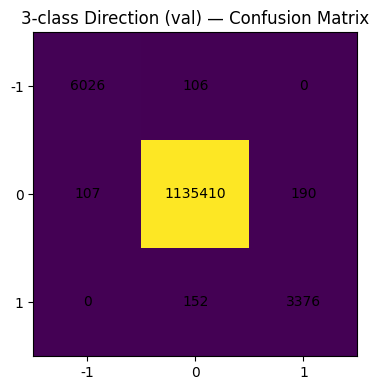

Saved predictions → C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\xgb_predictions.csv


In [ ]:

# =========================
# Validation metrics & confusion matrix (Cell 13)
# =========================
y_val_hat = clf.predict(X_val)
proba_val = getattr(clf, "predict_proba", lambda X: None)(X_val)

macro_f1 = f1_score(y_val, y_val_hat, average="macro")
weighted_f1 = f1_score(y_val, y_val_hat, average="weighted")
print("F1 (macro):", macro_f1)
print("F1 (weighted):", weighted_f1)
print(classification_report(y_val, y_val_hat, target_names=["-1","0","1"], digits=4))

cm = confusion_matrix(y_val, y_val_hat, labels=[0,1,2])
fig = plt.figure(figsize=(4,4))
ax = plt.gca()
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("3-class Direction (val) — Confusion Matrix")
ax.set_xticks([0,1,2]); ax.set_xticklabels(["-1","0","1"])
ax.set_yticks([0,1,2]); ax.set_yticklabels(["-1","0","1"])
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")
plt.tight_layout()
fig.savefig(OUTPUT_PLOT, dpi=160)
plt.show()

# =========================
# Build predictions DataFrame (includes tradable) — no LabelEncoder
# =========================
y_val_hat = clf.predict(X_val)                     # indices 0/1/2
proba_val = getattr(clf, "predict_proba", lambda X: None)(X_val)

# Decode using calibrated model's class order
classes_enc = np.asarray(getattr(clf, "classes_", np.array([0,1,2])))
classes_dec = _inv[classes_enc]                   # -> array([-1,0,1]) aligned with proba columns

pred_dir_val = _inv[y_val_hat]                    # {-1,0,1}

pred_df = pd.DataFrame({
    "timestamp": df.loc[val_idx, "timestamp"].values,
    "item": df.loc[val_idx, "item"].values if "item" in df.columns else "",
    "mid_price": df.loc[val_idx, "mid_price"].values if "mid_price" in df.columns else np.nan,
    "true_dir": _inv[y_val],                      # decode true labels too
    "pred_dir": pred_dir_val,
})

# carry tradable mask
pred_df["tradable"] = (df.loc[val_idx, "tradable"].values.astype("int8")
                       if "tradable" in df.columns else 1)

# attach class probabilities with decoded names
if proba_val is not None:
    for k, lab in enumerate(classes_dec):        # lab in {-1,0,1}
        pred_df[f"proba_{lab}"] = proba_val[:, k].astype("float32")

# backtester columns
pred_df["pred_label"] = pred_dir_val.astype("int8")
if proba_val is not None:
    # locate the +1 class position robustly
    buy_idx = int(np.where(classes_dec == 1)[0][0])
    pred_df["pred_proba_buy"] = proba_val[:, buy_idx].astype("float32")
else:
    pred_df["pred_proba_buy"] = (pred_df["pred_dir"] == 1).astype("float32")

pred_df.to_csv(OUTPUT_PREDICTIONS, index=False)
print(f"Saved predictions → {OUTPUT_PREDICTIONS}")


In [ ]:
# Backtester
# =========================
# Backtester (T+1, tradability-aware) (Cell 15)
# =========================
from pathlib import Path

PRED_PATH = OUTPUT_PREDICTIONS
TRADE_LOG_PATH = str(config.XGB_TRADE_LOG_CSV)
PLOTS_DIR = str(config.XGB_TRADING_DIR)
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

def run_backtest(
    df_sim: pd.DataFrame,
    *,
    initial_capital: float = 1_000_000_000.0,
    min_trade_amount: float = 10_000_000.0,
    max_trades_per_minute: int = 2,
    min_confidence: float = 0.90,
    exit_profit_threshold: float = 0.20,
    fee_bps: float = 100,         # roundtrip fee split equally per side
    slippage_bps: float = 0.0,    # extra per side slippage
    spread_bps: float = 10.0,     # synthetic spread if you don't have real bid/ask
    persist_bars: int = 20,        # require k consecutive signals before action
    median_window: int = 30,       # rolling median window for price stability
    impact_cap_bps: float = 200.0,# max effective move per bar for fills
    max_positions_per_item: int = 1,
    cooldown_minutes: int = 0,
    bar_seconds: int = 60,
    alpha: float = 7.0
):
    """
    Causal backtest with microstructure guards + TRADABILITY GATE:
      • Refuses ENTRY when `tradable==0`.
      • Defers EXIT when `tradable==0` (position remains open).
      • T+1 execution, buys at synthetic ask, sells at synthetic bid.
    Expects columns: timestamp, item, mid_price, pred_label, pred_proba_buy, (optional) tradable.
    """
    required = {"timestamp","item","mid_price","pred_label","pred_proba_buy"}
    missing = required - set(df_sim.columns)
    if missing:
        raise ValueError(f"Backtest missing columns: {sorted(missing)}")

    has_tradable = "tradable" in df_sim.columns

    # 0) Dedup & strict ordering
    df = df_sim.sort_values(["timestamp","item"]).drop_duplicates(["item","timestamp"], keep="last").reset_index(drop=True)

    # 1) Exec time = next bar (T+1)
    df["exec_time"]   = (df["timestamp"] + bar_seconds).astype("float64")
    df["exec_minute"] = (df["exec_time"] // bar_seconds).astype("int64")

    # 2) Rolling median mid per item for stability
    df["mid_med"] = df.groupby("item", sort=False)["mid_price"] \
                      .transform(lambda s: s.rolling(median_window, min_periods=1).median())

    # 3) State
    capital = float(initial_capital)
    inventory = []          # dicts: item, entry_time, entry_price, size, confidence, entry_minute
    trade_log = []
    last_seen = {}          # item -> (mid_med, ts)
    last_exit_minute = {}   # item -> minute
    buy_streak, sell_streak = {}, {}

    half_spread = (spread_bps / 20000.0)
    fee_buy_mult  = 1.0 + (fee_bps / 20000.0) + (slippage_bps / 10000.0)
    fee_sell_mult = 1.0 - (fee_bps / 20000.0) - (slippage_bps / 10000.0)

    equity_rows = []
    current_minute = None
    trades_this_minute = 0

    def minute_of(ts: float) -> int:
        return int(ts // bar_seconds)

    def snapshot(minute: int, ts: float):
        if minute is None: return
        invested = 0.0
        for pos in inventory:
            mid_med = last_seen.get(pos["item"], (pos["entry_price"], ts))[0]
            bid = mid_med * (1.0 - half_spread)
            invested += pos["size"] * bid
        equity = capital + invested
        equity_rows.append({
            "minute": minute,
            "timestamp": ts,
            "capital": capital,
            "invested": invested,
            "equity": equity,
            "invested_pct": invested / equity if equity > 0 else 0.0,
            "num_positions": len(inventory),
        })

    # Build timeline
    timeline = np.unique(np.concatenate([df["timestamp"].to_numpy(), df["exec_time"].to_numpy()]))
    timeline.sort()

    for ts in timeline:
        minute = minute_of(ts)

        # minute snapshot on boundary
        if current_minute is None:
            current_minute = minute
            trades_this_minute = 0
        elif minute != current_minute:
            snapshot(current_minute, ts)
            current_minute = minute
            trades_this_minute = 0

        # (A) Update last_seen from raw rows at this timestamp (filtered mid)
        raw_rows = df[df["timestamp"] == ts]
        for _, row in raw_rows.iterrows():
            item = str(row["item"])
            mid_med = float(row["mid_med"])
            last_seen[item] = (mid_med, float(row["timestamp"]))

        # (B) Process exec rows (actions evaluated at exec_time == ts)
        exec_rows = df[df["exec_time"] == ts]
        if len(exec_rows) == 0:
            continue

        # --- Exits first ---
        for _, row in exec_rows.iterrows():
            item = str(row["item"])
            # TRADABILITY EXIT GUARD
            if has_tradable and int(row.get("tradable", 1)) == 0:
                # defer exit; keep position unchanged
                continue

            pred = int(row["pred_label"])
            conf = float(row["pred_proba_buy"])
            buy_streak[item]  = buy_streak.get(item, 0)  + (1 if (pred == 1 and conf >= min_confidence) else 0 if pred == 1 else 0)
            sell_streak[item] = sell_streak.get(item, 0) + (1 if (pred == -1 and conf >= (1 - min_confidence)) else 0 if pred == -1 else 0)

            # Use filtered mid for tradable bid/ask (capped)
            mid_med = last_seen.get(item, (float(row["mid_med"]), ts))[0]
            if item in last_seen:
                prev_mid = last_seen[item][0]
                max_move = (impact_cap_bps / 10000.0)
                delta = np.clip(mid_med / max(prev_mid, 1e-12), 1.0 - max_move, 1.0 + max_move)
                mid_med = prev_mid * delta
            bid = mid_med * (1.0 - half_spread)

            updated = []
            for pos in inventory:
                if pos["item"] != item:
                    updated.append(pos); continue
                # No same-bar exit
                if minute <= pos["entry_minute"]:
                    updated.append(pos); continue

                exit_price = bid * fee_sell_mult
                held_ret = (exit_price - pos["entry_price"]) / pos["entry_price"]

                flip_ready = (sell_streak.get(item, 0) >= persist_bars)
                should_exit = (held_ret >= exit_profit_threshold) or flip_ready

                if should_exit:
                    pnl = (exit_price - pos["entry_price"]) * pos["size"]
                    capital += pos["size"] * exit_price
                    dur_sec = float(ts - pos["entry_time"])
                    trade_log.append({
                        "item": item,
                        "entry_time": pos["entry_time"],
                        "exit_time": ts,
                        "duration_sec": dur_sec,
                        "duration_min": dur_sec / 60.0,
                        "entry_price": pos["entry_price"],
                        "exit_price": exit_price,
                        "size": pos["size"],
                        "pnl": pnl,
                        "return": held_ret,
                        "confidence": pos["confidence"],
                        "reason": ("tp" if held_ret >= exit_profit_threshold else "flip_persist")
                    })
                    last_exit_minute[item] = minute
                else:
                    updated.append(pos)
            inventory = updated

        # --- Entries after exits ---
        for _, row in exec_rows.iterrows():
            item = str(row["item"])

            # TRADABILITY ENTRY GUARD
            if has_tradable and int(row.get("tradable", 1)) == 0:
                continue  # cannot buy when there is no book

            pred = int(row["pred_label"])
            conf = float(row["pred_proba_buy"])

            if pred != 1 or conf < min_confidence or trades_this_minute >= max_trades_per_minute:
                continue
            if cooldown_minutes > 0 and item in last_exit_minute:
                if minute - last_exit_minute[item] < cooldown_minutes:
                    continue
            # Require signal persistence
            if buy_streak.get(item, 0) < persist_bars:
                continue

            # Tradable ask from filtered mid (+ impact cap)
            mid_med = last_seen.get(item, (float(row["mid_med"]), ts))[0]
            if item in last_seen:
                prev_mid = last_seen[item][0]
                max_move = (impact_cap_bps / 10000.0)
                delta = np.clip(mid_med / max(prev_mid, 1e-12), 1.0 - max_move, 1.0 + max_move)
                mid_med = prev_mid * delta
            ask = mid_med * (1.0 + half_spread)
            entry_price = ask * fee_buy_mult
            if entry_price <= 0:
                continue

            # Position limits and budget
            n_open = sum(1 for p in inventory if p["item"] == item)
            if n_open >= max_positions_per_item:
                continue

            scaled = ((conf - min_confidence) / max(1e-6, 1.0 - min_confidence)) ** alpha
            budget = float(scaled * capital)
            if budget < min_trade_amount:
                continue
            size = int(budget / entry_price)
            if size < 1:
                continue

            capital -= size * entry_price
            inventory.append({
                "item": item,
                "entry_time": ts,
                "entry_minute": minute,
                "entry_price": entry_price,
                "size": size,
                "confidence": conf
            })
            last_seen[item] = (mid_med, ts)
            trades_this_minute += 1

    # Final snapshot and forced exits at bid
    if current_minute is not None and len(df):
        snapshot(current_minute, float(df["timestamp"].iloc[-1]))
    for pos in inventory:
        mid_med, last_time = last_seen.get(pos["item"], (pos["entry_price"], pos["entry_time"]))
        exit_time = max(last_time, pos["entry_time"] + bar_seconds)
        bid = mid_med * (1.0 - half_spread)
        exit_price = bid * fee_sell_mult
        pnl = (exit_price - pos["entry_price"]) * pos["size"]
        capital += pos["size"] * exit_price
        dur_sec = float(exit_time - pos["entry_time"])
        trade_log.append({
            "item": pos["item"],
            "entry_time": pos["entry_time"],
            "exit_time": exit_time,
            "duration_sec": dur_sec,
            "duration_min": dur_sec / 60.0,
            "entry_price": pos["entry_price"],
            "exit_price": exit_price,
            "size": pos["size"],
            "pnl": pnl,
            "return": (exit_price - pos["entry_price"]) / pos["entry_price"],
            "confidence": pos["confidence"],
            "reason": "final_close"
        })

    trades = pd.DataFrame(trade_log).sort_values("pnl", ascending=False).reset_index(drop=True)
    eq = pd.DataFrame(equity_rows).sort_values("minute").reset_index(drop=True)

    # Invariants
    if len(trades):
        assert (trades["exit_time"] > trades["entry_time"]).all(), "Exit must be strictly after entry (T+1)."
        if (trades["return"] > 1.0).any():
            print("[WARN] Trades with >100% return detected — check timestamp units and price scaling.")

    # Summary
    gross_profit = trades.loc[trades["pnl"] > 0, "pnl"].sum()
    gross_loss   = trades.loc[trades["pnl"] < 0, "pnl"].sum()
    avg_win = trades.loc[trades["pnl"] > 0, "return"].mean() if (trades["pnl"] > 0).any() else 0.0
    avg_loss = trades.loc[trades["pnl"] < 0, "return"].mean() if (trades["pnl"] < 0).any() else 0.0
    avg_duration = trades["duration_min"].mean() if len(trades) else 0.0

    summary = {
        "Final Capital": f"{capital:,.0f}",
        "Total Profit": f"{capital - initial_capital:,.0f}",
        "Num Trades": len(trades),
        "Win Rate": f"{(trades['pnl']>0).mean():.2%}" if len(trades) else "n/a",
        "Average Return / Trade": f"{trades['return'].mean():.2%}" if len(trades) else "n/a",
        "Average Win": f"{avg_win:.2%}",
        "Average Loss": f"{avg_loss:.2%}",
        "Gross Profit": f"{gross_profit:,.0f}",
        "Gross Loss": f"{gross_loss:,.0f}",
        "Profit Factor": f"{abs(gross_profit/gross_loss):.2f}" if gross_loss < 0 else "∞",
        "Average Duration (min)": f"{avg_duration:.2f}",
    }

    return trades, summary, eq

# --- Load predictions and enforce single row per (item,timestamp)
preds = pd.read_csv(PRED_PATH)
preds = preds.sort_values(["timestamp","item"]).drop_duplicates(["item","timestamp"], keep="last")
# Safety: ensure columns exist
if "pred_label" not in preds.columns and "pred_dir" in preds.columns:
    preds["pred_label"] = preds["pred_dir"].astype("int8")
if "pred_proba_buy" not in preds.columns:
    if "proba_1" in preds.columns:
        preds["pred_proba_buy"] = preds["proba_1"].astype("float32")
    else:
        preds["pred_proba_buy"] = (preds["pred_label"] == 1).astype("float32")
if "tradable" not in preds.columns:
    preds["tradable"] = 1



In [ ]:
# --- Run backtest (tweak fees/slippage here)
trades, summary, equity = run_backtest(
    preds,
    fee_bps=100,
    slippage_bps=0.0,
    cooldown_minutes=15,
    bar_seconds=60,
    min_trade_amount=10_000_000,
    min_confidence=0.3, 
    persist_bars=10,
    exit_profit_threshold=.2,
    alpha=1,
    max_trades_per_minute=1,
    max_positions_per_item=1,
)

# Save trade log
Path(os.path.dirname(str(config.XGB_TRADE_LOG_CSV))).mkdir(parents=True, exist_ok=True)
trades.to_csv(str(config.XGB_TRADE_LOG_CSV), index=False)

print("[Backtest summary]")
for k, v in summary.items():
    print(f"{k}: {v}")


[Backtest summary]
Final Capital: 1,870,023,321
Total Profit: 870,023,321
Num Trades: 6
Win Rate: 83.33%
Average Return / Trade: 15.23%
Average Win: 21.55%
Average Loss: -16.38%
Gross Profit: 935,779,074
Gross Loss: -65,755,753
Profit Factor: 14.23
Average Duration (min): 664.11


[diag] Saving plots to: C:\Users\reyno\Documents\GitHub\Project-BLD\Outputs\Trading\XGB_Trading


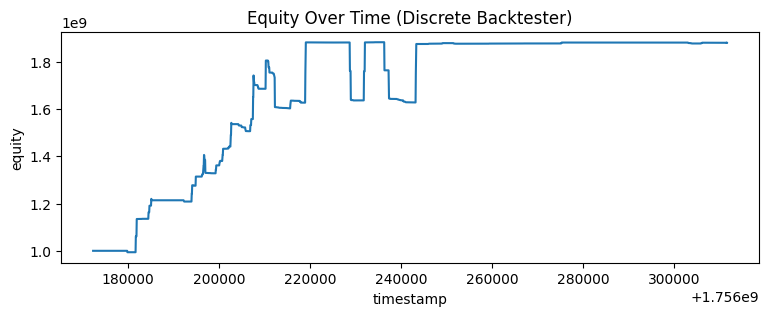

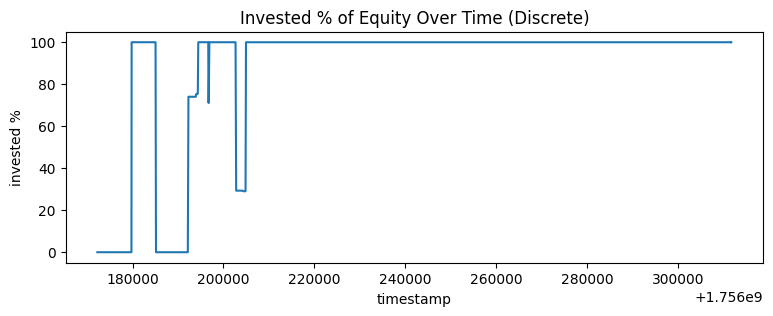

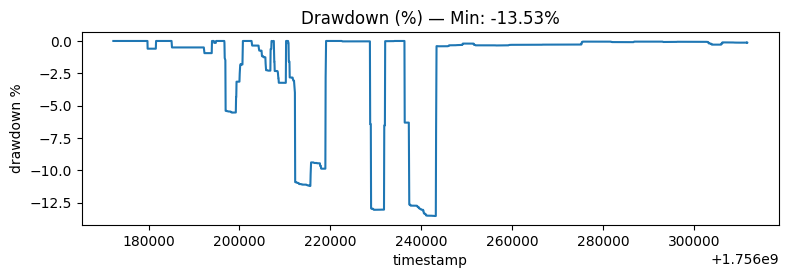

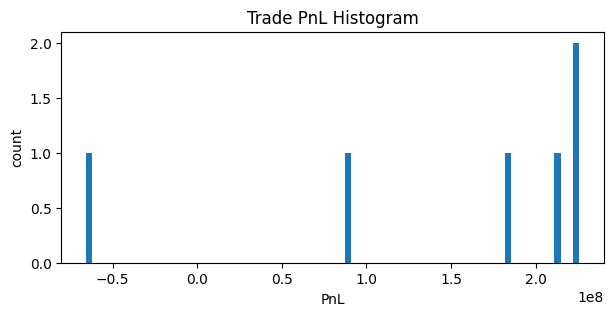

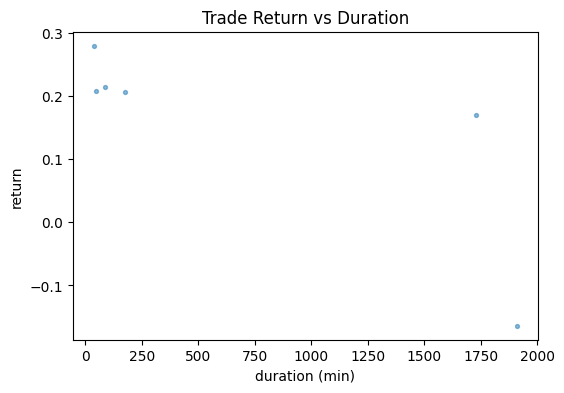

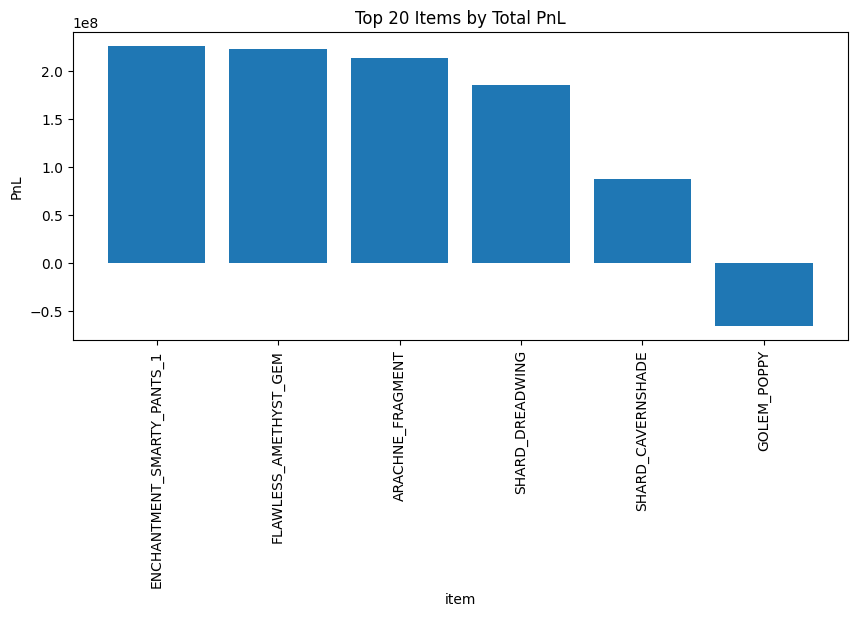

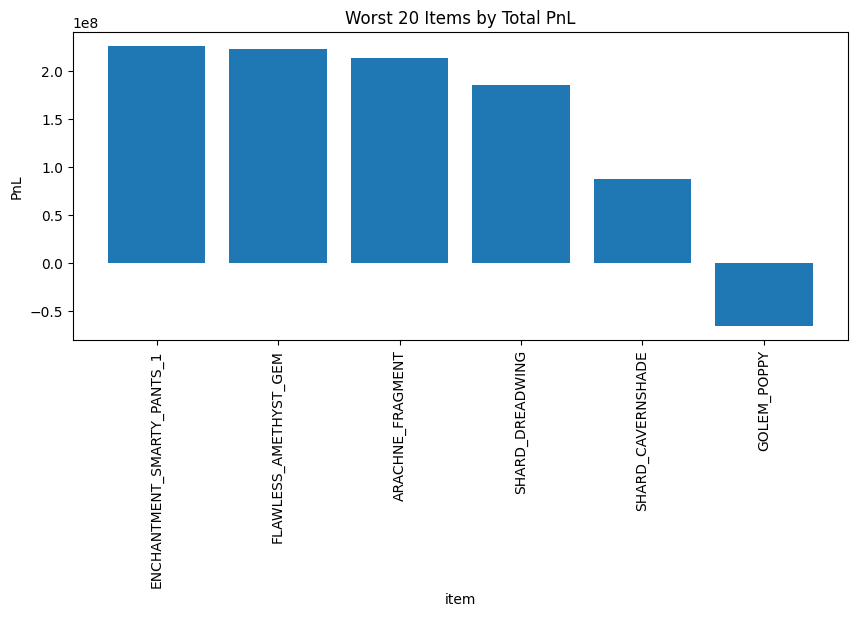

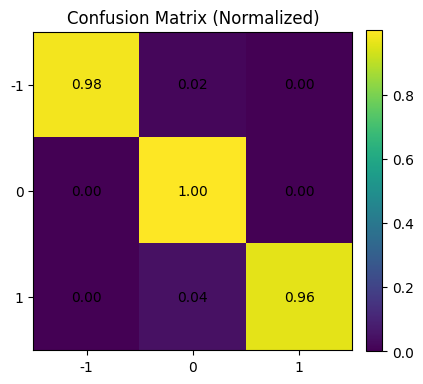

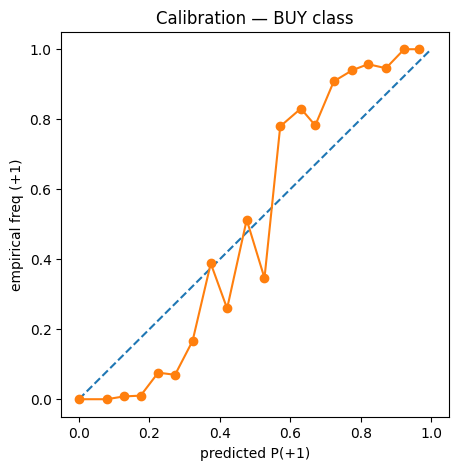

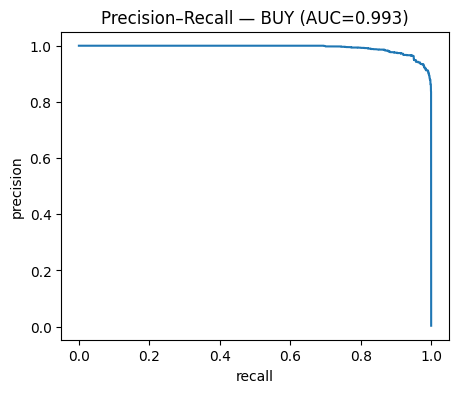

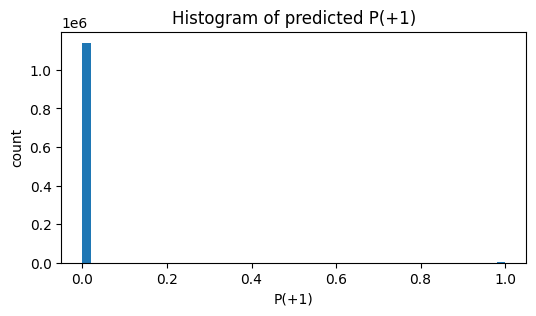

C:\Users\reyno\AppData\Local\Temp\ipykernel_5328\3848201196.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = dj.groupby('dec')['fwd_up_ret'].mean()


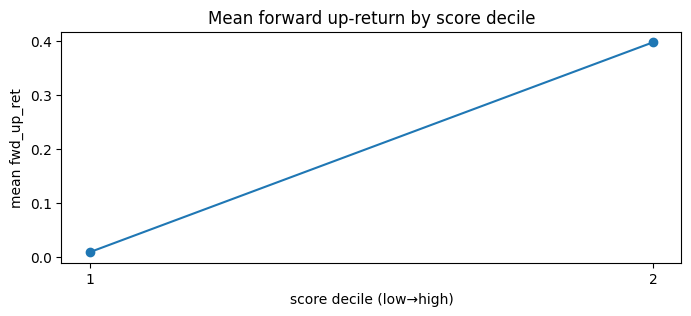

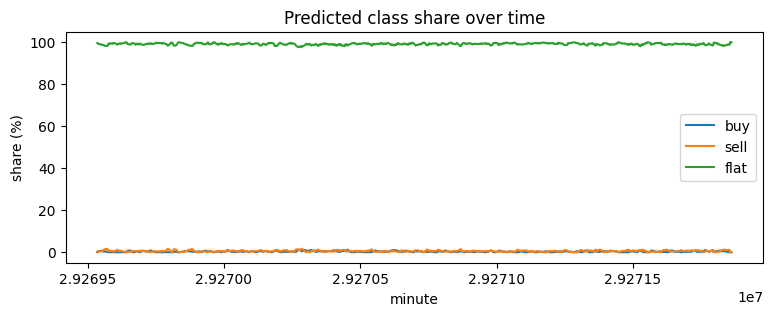

[diag] No XGBoost booster available; skipping feature plot.
[diag] Done.


In [ ]:
# === CELL PLOTS (NEW): Robust diagnostics & sanity graphs (discrete backtester) ===
import os, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

PLOTS_DIR = str(config.XGB_TRADING_DIR)
os.makedirs(PLOTS_DIR, exist_ok=True)

def _save_fig(fig, name: str, dpi=160):
    path = os.path.join(PLOTS_DIR, name)
    fig.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    return path

print(f"[diag] Saving plots to: {PLOTS_DIR}")

# ---------- 1) Equity & exposure ----------
if 'equity' in globals() and isinstance(equity, pd.DataFrame) and len(equity):
    # Equity curve
    fig = plt.figure(figsize=(9,3))
    ax = plt.gca()
    ax.plot(equity["timestamp"].values, equity["equity"].values)
    ax.set_title("Equity Over Time (Discrete Backtester)")
    ax.set_xlabel("timestamp")
    ax.set_ylabel("equity")
    p = _save_fig(fig, "equity_curve_discrete.png")

    # Invested % curve
    if "invested_pct" in equity.columns:
        fig = plt.figure(figsize=(9,3))
        ax = plt.gca()
        ax.plot(equity["timestamp"].values, 100*equity["invested_pct"].values)
        ax.set_title("Invested % of Equity Over Time (Discrete)")
        ax.set_xlabel("timestamp"); ax.set_ylabel("invested %")
        p = _save_fig(fig, "invested_curve_discrete.png")

    # Drawdown curve (from equity)
    e = equity["equity"].astype(float).to_numpy()
    peaks = np.maximum.accumulate(e)
    dd = (e - peaks) / np.maximum(peaks, 1e-12)
    fig = plt.figure(figsize=(9,2.5))
    ax = plt.gca()
    ax.plot(equity["timestamp"].values, 100*dd)
    ax.set_title(f"Drawdown (%) — Min: {100*dd.min():.2f}%")
    ax.set_xlabel("timestamp"); ax.set_ylabel("drawdown %")
    p = _save_fig(fig, "drawdown_curve_discrete.png")
else:
    print("[diag] Skipping equity/exposure plots — 'equity' missing or empty.")

# ---------- 2) Trade diagnostics ----------
if 'trades' in globals() and isinstance(trades, pd.DataFrame) and len(trades):
    # PnL histogram
    if "pnl" in trades.columns:
        fig = plt.figure(figsize=(7,3))
        ax = plt.gca()
        ax.hist(trades["pnl"].astype(float).values, bins=80)
        ax.set_title("Trade PnL Histogram")
        ax.set_xlabel("PnL"); ax.set_ylabel("count")
        p = _save_fig(fig, "trades_pnl_hist.png")

    # Duration vs return scatter
    if {"duration_min","return"}.issubset(trades.columns):
        fig = plt.figure(figsize=(6,4))
        ax = plt.gca()
        x = trades["duration_min"].astype(float).values
        y = trades["return"].astype(float).values
        ax.scatter(x, y, s=8, alpha=0.5)
        ax.set_title("Trade Return vs Duration")
        ax.set_xlabel("duration (min)"); ax.set_ylabel("return")
        p = _save_fig(fig, "trades_return_vs_duration.png")

    # Top/Bottom items by total PnL
    if "item" in trades.columns and "pnl" in trades.columns:
        agg = (trades.groupby("item", as_index=False)["pnl"]
                    .sum()
                    .sort_values("pnl", ascending=False))
        topN = 20
        head = agg.head(topN)
        fig = plt.figure(figsize=(10,4))
        ax = plt.gca()
        ax.bar(range(len(head)), head["pnl"].values)
        ax.set_xticks(range(len(head)))
        ax.set_xticklabels(head["item"].values, rotation=90)
        ax.set_title(f"Top {topN} Items by Total PnL")
        ax.set_xlabel("item"); ax.set_ylabel("PnL")
        p = _save_fig(fig, "top_items_pnl_discrete.png")

        tail = agg.tail(topN)
        fig = plt.figure(figsize=(10,4))
        ax = plt.gca()
        ax.bar(range(len(tail)), tail["pnl"].values)
        ax.set_xticks(range(len(tail)))
        ax.set_xticklabels(tail["item"].values, rotation=90)
        ax.set_title(f"Worst {topN} Items by Total PnL")
        ax.set_xlabel("item"); ax.set_ylabel("PnL")
        p = _save_fig(fig, "worst_items_pnl_discrete.png")
else:
    print("[diag] Skipping trade diagnostics — 'trades' missing or empty.")

# ---------- 3) Confusion matrix (normalized) ----------
try:
    # y_val and y_val_hat should exist from Cell 13
    if 'y_val' in globals():
        if 'y_val_hat' not in globals():
            y_val_hat = clf.predict(X_val)
        cm = confusion_matrix(y_val, y_val_hat, labels=[0,1,2])
        cm_norm = cm.astype(float) / np.maximum(cm.sum(axis=1, keepdims=True), 1.0)

        fig = plt.figure(figsize=(4.5,4.5))
        ax = plt.gca()
        im = ax.imshow(cm_norm, interpolation="nearest")
        ax.set_title("Confusion Matrix (Normalized)")
        ax.set_xticks([0,1,2]); ax.set_xticklabels(["-1","0","1"])
        ax.set_yticks([0,1,2]); ax.set_yticklabels(["-1","0","1"])
        for (i, j), v in np.ndenumerate(cm_norm):
            ax.text(j, i, f"{v:.2f}", ha="center", va="center")
        fig.colorbar(im, fraction=0.046, pad=0.04)
        p = _save_fig(fig, "confusion_matrix_normalized.png")
except Exception as e:
    print(f"[diag] Confusion matrix skipped: {e}")

# ---------- 4) Calibration & PR curve for the BUY class (+1) ----------
try:
    # proba_val from Cell 13; else compute
    if 'proba_val' not in globals() or proba_val is None:
        proba_val = clf.predict_proba(X_val)

    # Map model class indices back to {-1,0,1} using classes_dec (Cell 13)
    if 'classes_dec' not in globals():
        classes_enc = np.asarray(getattr(clf, "classes_", np.array([0,1,2])))
        _inv = np.array([-1, 0, 1])
        classes_dec = _inv[classes_enc]

    buy_idx = int(np.where(classes_dec == 1)[0][0])
    y_true_buy = (y_val == buy_idx).astype(int)
    p_buy = proba_val[:, buy_idx].astype(float)

    # Reliability diagram (bin by predicted prob, plot mean predicted vs empirical)
    bins = np.linspace(0, 1, 21)
    inds = np.digitize(p_buy, bins) - 1
    cal_x, cal_y, cnts = [], [], []
    for b in range(len(bins)-1):
        m = inds == b
        if not m.any(): 
            continue
        cal_x.append(np.mean(p_buy[m]))
        cal_y.append(np.mean(y_true_buy[m]))
        cnts.append(m.sum())

    fig = plt.figure(figsize=(5,5))
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle="--")
    ax.plot(cal_x, cal_y, marker="o")
    ax.set_title("Calibration — BUY class")
    ax.set_xlabel("predicted P(+1)"); ax.set_ylabel("empirical freq (+1)")
    p = _save_fig(fig, "calibration_buy.png")

    # Precision–Recall
    prec, rec, thr = precision_recall_curve(y_true_buy, p_buy)
    pr_auc = auc(rec, prec)
    fig = plt.figure(figsize=(5,4))
    ax = plt.gca()
    ax.plot(rec, prec)
    ax.set_title(f"Precision–Recall — BUY (AUC={pr_auc:.3f})")
    ax.set_xlabel("recall"); ax.set_ylabel("precision")
    p = _save_fig(fig, "pr_curve_buy.png")

    # Probability histogram
    fig = plt.figure(figsize=(6,3))
    ax = plt.gca()
    ax.hist(p_buy, bins=50)
    ax.set_title("Histogram of predicted P(+1)")
    ax.set_xlabel("P(+1)"); ax.set_ylabel("count")
    p = _save_fig(fig, "proba_hist_buy.png")
except Exception as e:
    print(f"[diag] Calibration/PR skipped: {e}")

# ---------- 5) Score vs Forward Opportunity (from opp_joined) ----------
try:
    if 'opp_joined' in globals() and isinstance(opp_joined, pd.DataFrame) and len(opp_joined):
        # Decile plot: average fwd_up_ret by score decile
        dj = opp_joined.dropna(subset=['score','fwd_up_ret']).copy()
        if len(dj) > 0:
            dj['dec'] = pd.qcut(dj['score'], 10, duplicates='drop')
            g = dj.groupby('dec')['fwd_up_ret'].mean()
            fig = plt.figure(figsize=(8,3))
            ax = plt.gca()
            ax.plot(range(len(g)), g.values, marker="o")
            ax.set_xticks(range(len(g)))
            ax.set_xticklabels([f"{i+1}" for i in range(len(g))])
            ax.set_title("Mean forward up-return by score decile")
            ax.set_xlabel("score decile (low→high)"); ax.set_ylabel("mean fwd_up_ret")
            p = _save_fig(fig, "score_vs_fwd_up_ret_deciles.png")
    else:
        print("[diag] Skipping score→opportunity plot — 'opp_joined' missing or empty.")
except Exception as e:
    print(f"[diag] Score→opportunity plot skipped: {e}")

# ---------- 6) Class prevalence over time (predicted) ----------
try:
    if 'preds_test' in globals() and isinstance(preds_test, pd.DataFrame) and len(preds_test):
        pt = preds_test.copy()
        if "timestamp" in pt.columns:
            pt['minute'] = (pt['timestamp'] // 60).astype(int)
            # prevalence: share of positive/negative among rows in each minute
            has_cols = {'Pm1','P0','Pp1'}.issubset(pt.columns)
            if has_cols:
                pt['pred_idx'] = np.argmax(pt[['Pm1','P0','Pp1']].to_numpy(), axis=1)
                # map to {-1,0,1}
                idx_to_label = {-1:0, 0:1, 1:2}  # inverse of earlier mapping
                # Actually we want label: -1 if pred_idx==0, 0 if 1, 1 if 2
                pt['pred_label'] = pt['pred_idx'].map({0:-1,1:0,2:1}).astype(int)
                m = pt.groupby('minute')['pred_label'].apply(lambda s: pd.Series({
                    'share_buy': (s==1).mean(),
                    'share_sell': (s==-1).mean(),
                    'share_flat': (s==0).mean()
                })).unstack()
                fig = plt.figure(figsize=(9,3))
                ax = plt.gca()
                ax.plot(m.index.values, 100*m['share_buy'].values, label="buy")
                ax.plot(m.index.values, 100*m['share_sell'].values, label="sell")
                ax.plot(m.index.values, 100*m['share_flat'].values, label="flat")
                ax.legend()
                ax.set_title("Predicted class share over time")
                ax.set_xlabel("minute"); ax.set_ylabel("share (%)")
                p = _save_fig(fig, "predicted_class_share_over_time.png")
except Exception as e:
    print(f"[diag] Class prevalence over time skipped: {e}")

# ---------- 7) Simple feature importance (tree-based gain, if available) ----------
try:
    booster = getattr(clf, "get_booster", lambda: None)()
    if booster is not None:
        # XGBoost importance by 'gain' (fallback to 'weight' if needed)
        try:
            score = booster.get_score(importance_type='gain')
        except Exception:
            score = booster.get_score(importance_type='weight')
        if score:
            imp = pd.DataFrame({"feature": list(score.keys()),
                                "importance": list(score.values())}).sort_values("importance", ascending=False).head(25)
            fig = plt.figure(figsize=(8,5))
            ax = plt.gca()
            ax.barh(imp["feature"].values[::-1], imp["importance"].values[::-1])
            ax.set_title("Top 25 Features (XGBoost importance)")
            ax.set_xlabel("importance"); ax.set_ylabel("feature")
            p = _save_fig(fig, "xgb_feature_importance_top25.png")
        else:
            print("[diag] Booster returned empty importance; skipping feature plot.")
    else:
        print("[diag] No XGBoost booster available; skipping feature plot.")
except Exception as e:
    print(f"[diag] Feature importance plot skipped: {e}")

print("[diag] Done.")


In [ ]:
# Use opp_joined from Cell C (Cell 20)
q = pd.qcut(opp_joined['score'], 10, duplicates='drop')
by = opp_joined.groupby(q).agg(
    up_ret_mean=('fwd_up_ret','mean'),
    dn_ret_mean=('fwd_dn_ret','mean'),
    buy_rate=('score', lambda s: (s>0).mean()),
    n=('score','size')
).round(4)
print(by)


               up_ret_mean  dn_ret_mean  buy_rate        n
score                                                     
(-1.001, 0.0]       0.0094       0.0079       0.0  2479790
(0.0, 1.0]          0.3972       0.0286       1.0     9857


C:\Users\reyno\AppData\Local\Temp\ipykernel_5328\3609690174.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by = opp_joined.groupby(q).agg(


In [ ]:
# Requires: a table of entries from your discrete backtester named `trades` with entry_time and item (Cell 21)
# and your preds_test with per-minute score.
pt = preds_test[['timestamp','item','score','mid_price']].copy()
pt['minute'] = (pt['timestamp']//60).astype(int)
first_cross = (pt[pt['score']>0].groupby('item')['timestamp'].min()).rename('first_ts')
entries = trades.groupby('item')['entry_time'].min().rename('entry_ts')
lag = entries.to_frame().join(first_cross, how='inner')
lag['lag_min'] = (lag['entry_ts'] - lag['first_ts'])/60.0
print(lag.describe())
au = equity['invested_pct'].mean()
print(f"Average invested% over test: {au:.1%}")

           entry_ts      first_ts     lag_min
count  1.000000e+01  1.000000e+01   10.000000
mean   1.756203e+09  1.756188e+09  244.666667
std    1.660371e+04  1.331516e+04  186.993431
min    1.756180e+09  1.756172e+09   31.000000
25%    1.756193e+09  1.756174e+09  116.833333
50%    1.756201e+09  1.756192e+09  211.000000
75%    1.756216e+09  1.756197e+09  297.666667
max    1.756228e+09  1.756206e+09  586.000000
Average invested% over test: 89.0%


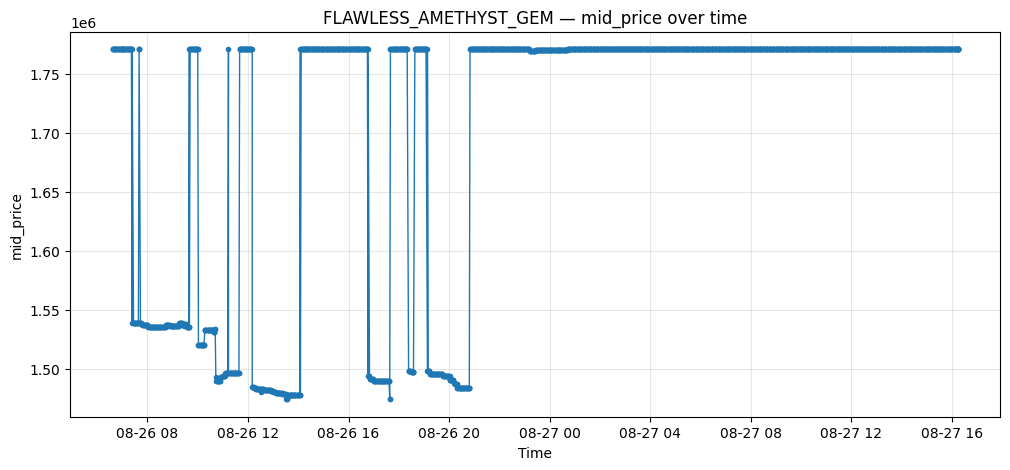

In [ ]:

# =========================
# Helper: plot a feature/time series for one item (Cell 24)
# =========================
def plot_item_feature(df_any, item_name: str, feature: str = "mid_price", n_points: int | None = None):
    dfi = df_any[df_any.get("item","") == item_name].copy()
    dfi = dfi.sort_values("timestamp")
    if n_points is not None:
        dfi = dfi.tail(n_points)
    if dfi.empty:
        print(f"No data found for item {item_name}"); return
    try:
        x = pd.to_datetime(dfi["timestamp"], unit="s")
    except Exception:
        x = dfi["timestamp"]
    plt.figure(figsize=(12,5))
    plt.plot(x, dfi[feature], marker=".", linewidth=1)
    plt.title(f"{item_name} — {feature} over time")
    plt.xlabel("Time")
    plt.ylabel(feature)
    plt.grid(True, alpha=0.3)
    plt.show()

# Example:
preds_loaded = pd.read_csv(OUTPUT_PREDICTIONS)
plot_item_feature(preds_loaded, "FLAWLESS_AMETHYST_GEM", feature="mid_price", n_points=2000)